# Imports

In [ ]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import numpy as np
import matplotlib as mpl
import re
import matplotlib.pyplot as plt
import scanpy.external as sce
import warnings

warnings.filterwarnings("ignore") 
sc.settings.verbosity = 3 
sc.settings.n_jobs = 1 
sns.set(font_scale=1)
sc.settings.set_figure_params(dpi=150)
sns.set_style("white")

# Data

For reading single cell data we will use scanpy library.

In [ ]:
!wget -O GSE116256_RAW.tar "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE116256&format=file"
!tar xf GSE116256_RAW.tar

--2022-05-30 14:55:56--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE116256&format=file
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73246720 (70M) [application/x-tar]
Saving to: ‘GSE116256_RAW.tar’

GSE116256_RAW.tar   100%[===================>]  69.85M  3.51MB/s    in 16s     

2022-05-30 14:56:14 (4.29 MB/s) - ‘GSE116256_RAW.tar’ saved [73246720/73246720]



In [ ]:
!gzip -d *.gz

In [ ]:
# prefixes for file names
file_names = [
    'GSM3587923_AML1012-D0',
    'GSM3587925_AML210A-D0',
    'GSM3587927_AML314-D0',
    'GSM3587931_AML328-D0',
    'GSM3587940_AML329-D0',
    'GSM3587946_AML371-D0',
    'GSM3587950_AML419A-D0',
    'GSM3587953_AML420B-D0',
    'GSM3587959_AML475-D0',
    'GSM3587963_AML556-D0',
    'GSM3587969_AML707B-D0',
    'GSM3587980_AML722B-D0',
    'GSM3587984_AML870-D0',
    'GSM3587988_AML916-D0',
    'GSM3587990_AML921A-D0',
    'GSM3587992_AML997-D0',
]

In [ ]:
# reading files

AMLadatas = []

for filename in file_names:
    AMLadata = sc.read_text('/content/' + filename + '.dem.txt').T
    AMLadata.obs["patient"] = filename
    AMLadatas.append(AMLadata.copy())

In [ ]:
AMLadata = AMLadatas[0].concatenate(AMLadatas[1:])
del AMLadata.obs["batch"] # removing batch because we have 'patient' as batch

In [ ]:
AMLadata.X

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 5.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from scipy import sparse

In [ ]:
AMLadata.X = sparse.csr_matrix(AMLadata.X) # replacing the data by sparse matrix for less space
AMLadata.X

<15685x27899 sparse matrix of type '<class 'numpy.float32'>'
	with 17322071 stored elements in Compressed Sparse Row format>

Calculating QC-metrics

In [ ]:
AMLadata.var["mt"] = AMLadata.var_names.str.startswith("MT-") # check if the genes are mitochondrial 
sc.pp.calculate_qc_metrics(AMLadata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True) # calculating QC-metrics

Filtering the cells with bimodal UMI distribution

Text(0.5, 1.0, 'Mitochondrial gene expression distribution')

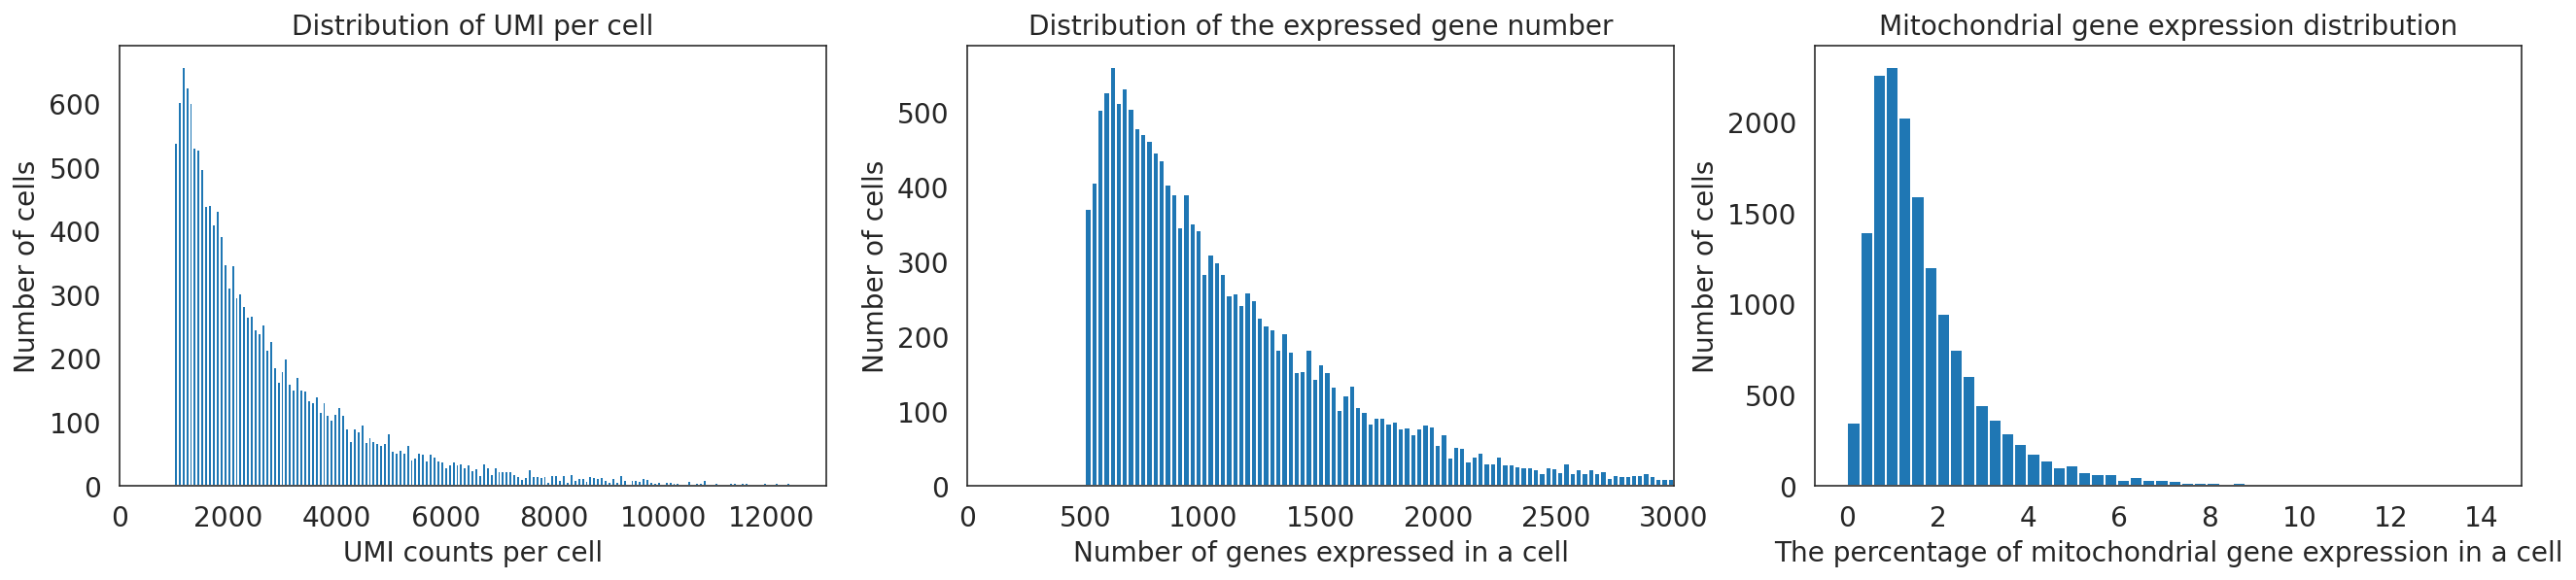

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(22, 4)) # preparing for drawing 3 plots

# Drawing the distribution of the total UMI counts
sns.distplot(AMLadata.obs["total_counts"], kde=False, ax=axs[0], hist_kws={"alpha":1}, bins=500)
axs[0].set_xlim(0, 13000)
axs[0].set_xlabel("UMI counts per cell")
axs[0].set_ylabel("Number of cells")
axs[0].set_title("Distribution of UMI per cell")

# Drawing the distribution of gene number per cells
sns.distplot(AMLadata.obs["n_genes_by_counts"], kde=False, ax=axs[1], hist_kws={"alpha":1}, bins=200)
axs[1].set_xlim(0, 3000)
axs[1].set_xlabel("Number of genes expressed in a cell")
axs[1].set_ylabel("Number of cells")
axs[1].set_title("Distribution of the expressed gene number")

# Drawing the distribution of the mitochondrial gene expression (up to 10% is considered as normal)
sns.distplot(AMLadata.obs["pct_counts_mt"], kde=False, ax=axs[2], hist_kws={"alpha":1})
axs[2].set_xlabel("The percentage of mitochondrial gene expression in a cell")
axs[2].set_ylabel("Number of cells")
axs[2].set_title("Mitochondrial gene expression distribution")

The elimination of doublets is a required step for single cell data preprocessing.


In [ ]:
import scrublet as scr # special package for the doublets removing

In [ ]:
scrub = scr.Scrublet(AMLadata.X)

In [ ]:
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.82
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 2.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 32.2 seconds


In [ ]:
is_singlet = np.logical_not(predicted_doublets) 
AMLadata = AMLadata[is_singlet] # keeping only the singlets
print(AMLadata)

View of AnnData object with n_obs × n_vars = 15685 × 27899
    obs: 'patient', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [ ]:
import re

ribosomal_mask = re.compile("^RP[SL][0-9]") # setting the mask for the ribosomal genes
AMLadata.var["ribo"] = [False if len(ribosomal_mask.findall(x)) == 0 else True for x in AMLadata.var_names] # finding all the ribosomal genes

AMLadata = AMLadata[:, np.logical_not(AMLadata.var.ribo)] # keeping all the genes except the ribosomal ones
AMLadata = AMLadata[:, np.logical_not(AMLadata.var.mt)] # keeping all the genes except the mitochondrial ones

Now each cell has a huge dimensionality (dimensionality = number of genes), so if we continue to work with such data the curse of dimensionality will arise. Therefore, the dimensionality must be reduced and so-called feature selection should be made. So, we select the most useful features with the highest variance.

In [ ]:
sc.pp.highly_variable_genes(AMLadata, n_top_genes=3000, flavor="seurat_v3",
                            batch_key="patient", span = 1)
#it is useful to indicate the batch! because this way we will discard genes that are variable between patients
#(and we want between different types of cells)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Since we have a variance in the number of UMI per cell, we normalize the data (by 1e4) and then take the logarithm.

In [ ]:
sc.pp.normalize_total(AMLadata, target_sum=1e4)
sc.pp.log1p(AMLadata)
AMLadata.raw = AMLadata # be sure to write the raw data to a separate slot!!!

normalizing counts per cell
    finished (0:00:00)


In [ ]:
AMLadata = AMLadata[:, AMLadata.var.highly_variable] # keeping only highly variable genes and then clustering by them

Let's make a regression on the percentage of mitochondrial RNA and the total number of counts to minimize their impact on subsequent analysis. If the expression of a certain gene correlates well with the percentage of the mitochondrial RNA (this is a purely technical thing), then the entire expression of this gene is technical noise.

In [ ]:
sc.pp.regress_out(AMLadata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:50)


Scaling the data so that we can compare the variance of different genes.

In [ ]:
sc.pp.scale(AMLadata)

Let's build a PCA and see if there is a batch in the data.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)


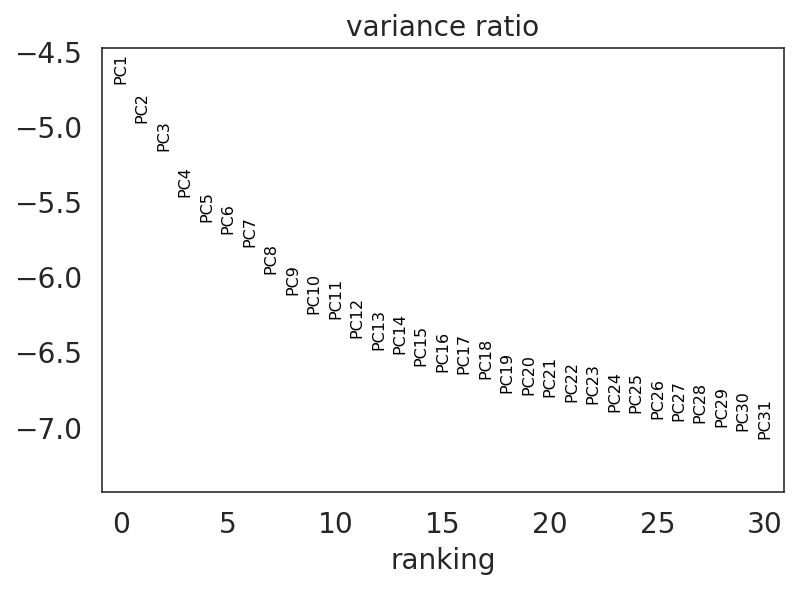

In [ ]:
sc.tl.pca(AMLadata)
sc.pl.pca_variance_ratio(AMLadata, log=True)

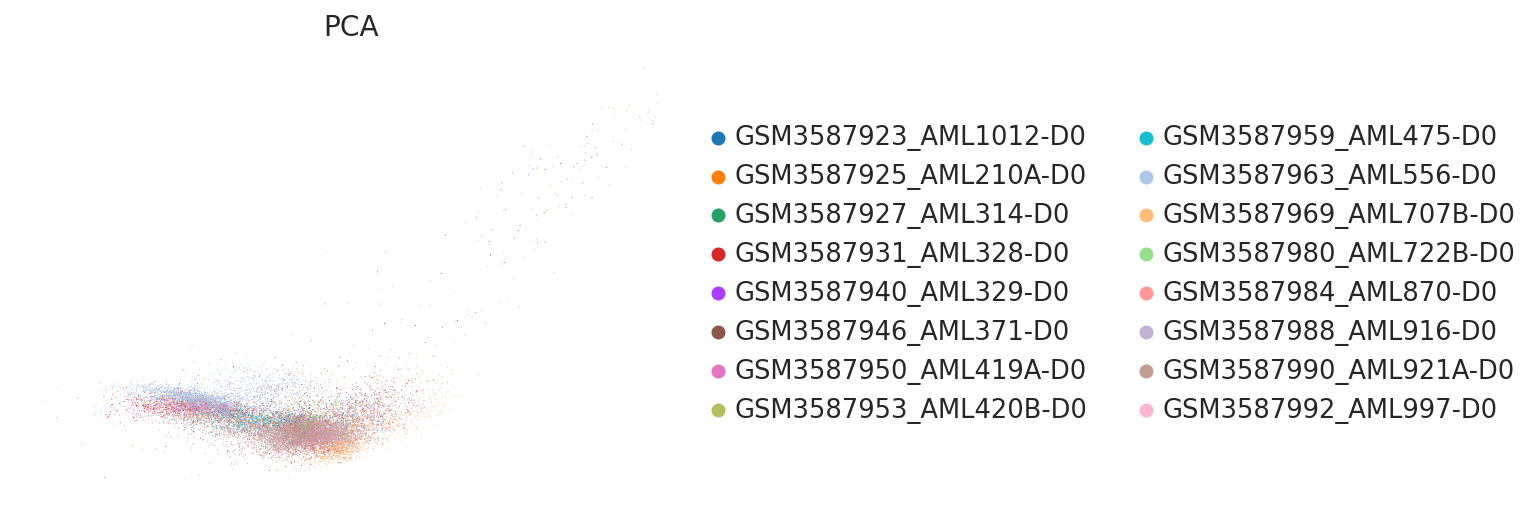

In [ ]:
sc.pl.pca(AMLadata, color="patient", frameon=False, title="PCA", s=1)

Eliminating the batch using the harmony method.

2022-05-30 15:04:37,791 - harmonypy - INFO - Iteration 1 of 10
2022-05-30 15:04:56,162 - harmonypy - INFO - Iteration 2 of 10
2022-05-30 15:05:11,964 - harmonypy - INFO - Iteration 3 of 10
2022-05-30 15:05:19,902 - harmonypy - INFO - Iteration 4 of 10
2022-05-30 15:05:27,715 - harmonypy - INFO - Iteration 5 of 10
2022-05-30 15:05:33,575 - harmonypy - INFO - Iteration 6 of 10
2022-05-30 15:05:38,410 - harmonypy - INFO - Iteration 7 of 10
2022-05-30 15:05:41,871 - harmonypy - INFO - Iteration 8 of 10
2022-05-30 15:05:45,733 - harmonypy - INFO - Iteration 9 of 10
2022-05-30 15:05:49,231 - harmonypy - INFO - Iteration 10 of 10
2022-05-30 15:05:53,511 - harmonypy - INFO - Converged after 10 iterations


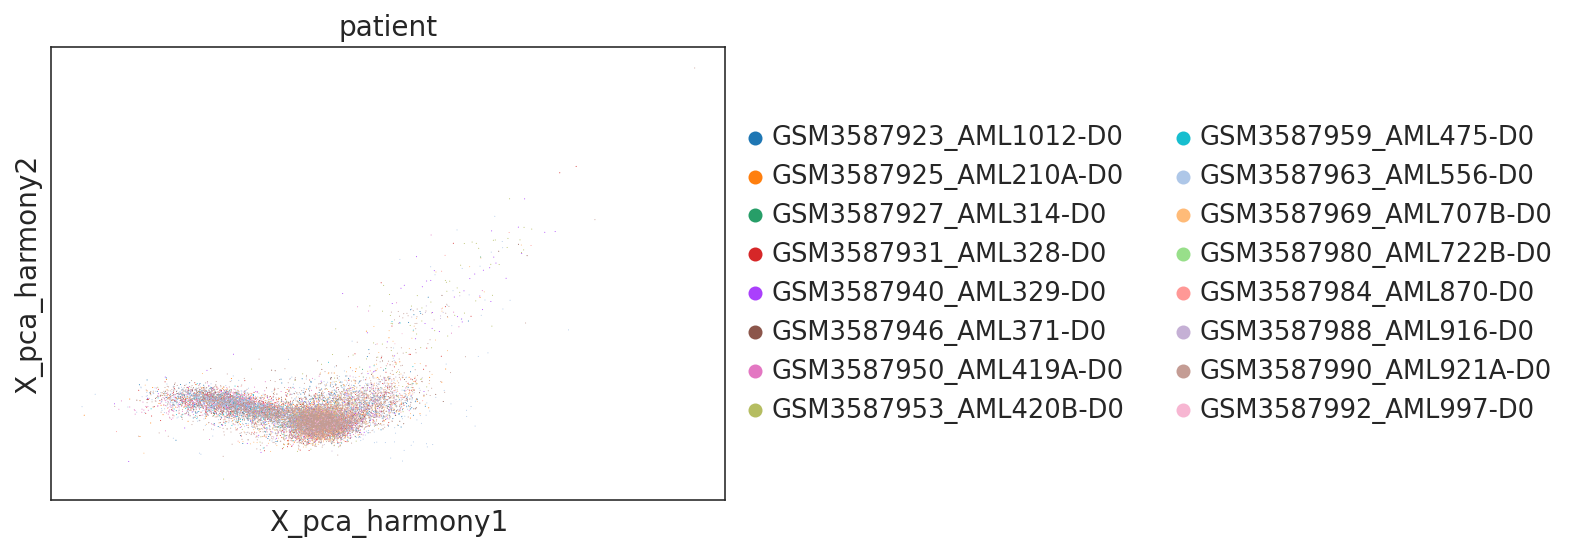

In [ ]:
sce.pp.harmony_integrate(AMLadata, key="patient", theta=2) # batch correction with the harmony method
sc.pl.embedding(AMLadata, color="patient", basis="X_pca_harmony", s=1)

Now let's build a graph of neighbors and display UMAP plot with marking by patient.

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:52)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)


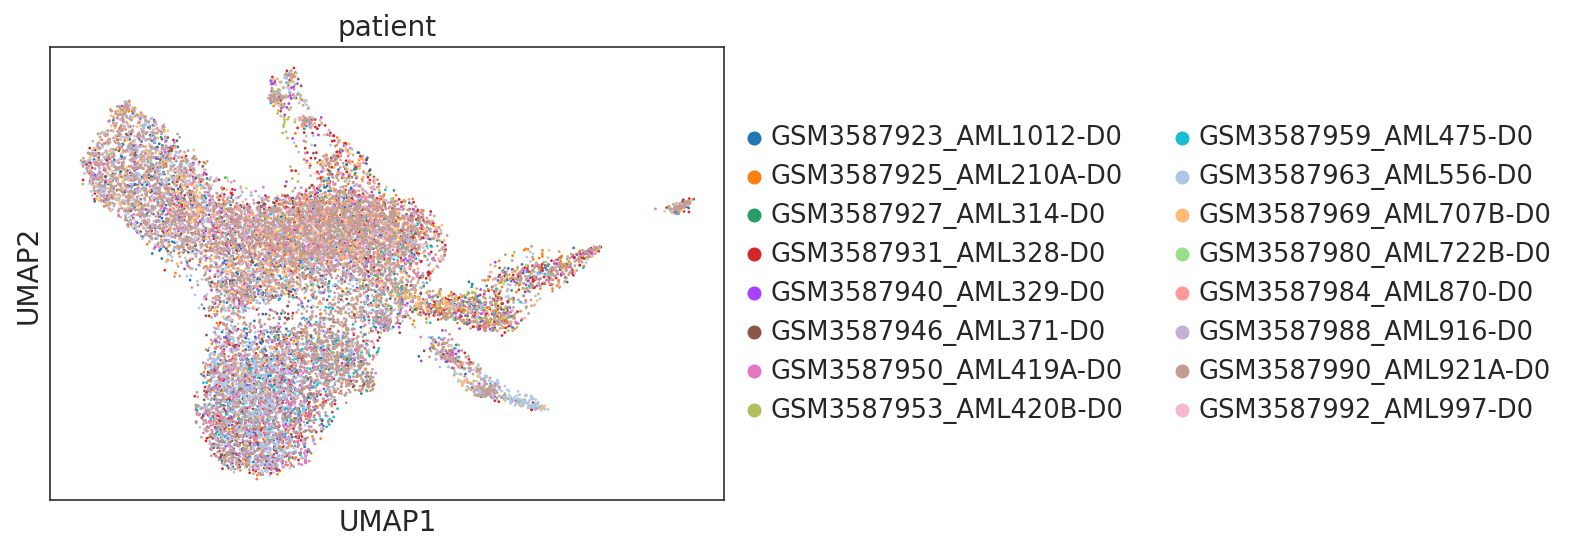

In [ ]:
sc.pp.neighbors(AMLadata, n_pcs=15, n_neighbors=50,
                use_rep="X_pca_harmony")
sc.tl.umap(AMLadata)
sc.pl.umap(AMLadata, color="patient")

Performing the clustering of cells by the Leiden method.

In [ ]:
sc.tl.leiden(AMLadata, resolution=1)

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:26)


Drawing the resulting clusters.

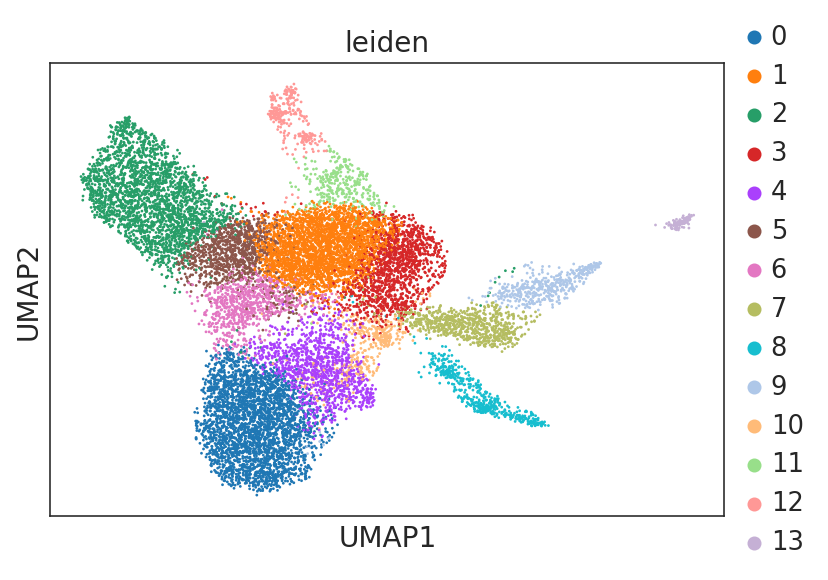

In [ ]:
sc.pl.umap(AMLadata, color="leiden")

## TFs visualization in single sells

Using the author's markup by cell types we can look at the expression of transcription factors in different bone marrow cell types

In [ ]:
file_names = [
    'GSM3587924_AML1012-D0',
    'GSM3587926_AML210A-D0',
    'GSM3587928_AML314-D0',
    'GSM3587932_AML328-D0',
    'GSM3587941_AML329-D0',
    'GSM3587947_AML371-D0',
    'GSM3587951_AML419A-D0',
    'GSM3587954_AML420B-D0',
    'GSM3587960_AML475-D0',
    'GSM3587964_AML556-D0',
    'GSM3587970_AML707B-D0',
    'GSM3587981_AML722B-D0',
    'GSM3587985_AML870-D0',
    'GSM3587989_AML916-D0',
    'GSM3587991_AML921A-D0',
    'GSM3587993_AML997-D0',
]

In [ ]:
AML = pd.DataFrame()

for name in file_names:
    AML = pd.concat([AML, pd.read_csv('/content/' + name + '.anno.txt', sep = '\t')])

In [ ]:
annot = pd.DataFrame(AML[['CellType', 'Cell']])
annot['ind'] = AML['Cell']
annot = annot.set_index('Cell')

In [ ]:
ind = []
for i in AMLadata.obs.index:
    ind.append(i[:-2])

In [ ]:
AMLadata.obs['ind'] = ind

In [ ]:
AMLadata.obs

,patient,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,ind
AML1012-D0_AAAAAGTTACGT-0,GSM3587923_AML1012-D0,670,1464.0,30.0,2.049180,1,AML1012-D0_AAAAAGTTACGT
AML1012-D0_AAAACACCAATC-0,GSM3587923_AML1012-D0,1713,4810.0,197.0,4.095634,1,AML1012-D0_AAAACACCAATC
AML1012-D0_AAAATAGCCTTT-0,GSM3587923_AML1012-D0,853,2305.0,90.0,3.904555,3,AML1012-D0_AAAATAGCCTTT
AML1012-D0_AAACATTAAACG-0,GSM3587923_AML1012-D0,976,2266.0,57.0,2.515446,6,AML1012-D0_AAACATTAAACG
AML1012-D0_AAACCACGTGCN-0,GSM3587923_AML1012-D0,744,1561.0,54.0,3.459321,1,AML1012-D0_AAACCACGTGCN
...,...,...,...,...,...,...,...
AML997-D0_GAGGATCCGGCT-15,GSM3587992_AML997-D0,972,3192.0,193.0,6.046366,12,AML997-D0_GAGGATCCGGCT-
AML997-D0_CGGTCGACGTCA-15,GSM3587992_AML997-D0,561,2222.0,6.0,0.270027,1,AML997-D0_CGGTCGACGTCA-
AML997-D0_AAGGTACGGATT-15,GSM3587992_AML997-D0,957,3422.0,11.0,0.321449,3,AML997-D0_AAGGTACGGATT-
AML997-D0_ATCGATGTCACC-15,GSM3587992_AML997-D0,859,2484.0,38.0,1.529791,3,AML997-D0_ATCGATGTCACC-


In [ ]:
ann_for_obs = list(AMLadata.obs.merge(annot, on = ['ind'], how = 'left')['CellType'])

In [ ]:
AMLadata.obs['CellType'] = ann_for_obs

In [ ]:
AMLadata.obs

,patient,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,ind,CellType
AML1012-D0_AAAAAGTTACGT-0,GSM3587923_AML1012-D0,670,1464.0,30.0,2.049180,1,AML1012-D0_AAAAAGTTACGT,GMP
AML1012-D0_AAAACACCAATC-0,GSM3587923_AML1012-D0,1713,4810.0,197.0,4.095634,1,AML1012-D0_AAAACACCAATC,GMP-like
AML1012-D0_AAAATAGCCTTT-0,GSM3587923_AML1012-D0,853,2305.0,90.0,3.904555,3,AML1012-D0_AAAATAGCCTTT,Prog-like
AML1012-D0_AAACATTAAACG-0,GSM3587923_AML1012-D0,976,2266.0,57.0,2.515446,6,AML1012-D0_AAACATTAAACG,ProMono-like
AML1012-D0_AAACCACGTGCN-0,GSM3587923_AML1012-D0,744,1561.0,54.0,3.459321,1,AML1012-D0_AAACCACGTGCN,Prog-like
...,...,...,...,...,...,...,...,...
AML997-D0_GAGGATCCGGCT-15,GSM3587992_AML997-D0,972,3192.0,193.0,6.046366,12,AML997-D0_GAGGATCCGGCT-,NaN
AML997-D0_CGGTCGACGTCA-15,GSM3587992_AML997-D0,561,2222.0,6.0,0.270027,1,AML997-D0_CGGTCGACGTCA-,NaN
AML997-D0_AAGGTACGGATT-15,GSM3587992_AML997-D0,957,3422.0,11.0,0.321449,3,AML997-D0_AAGGTACGGATT-,NaN
AML997-D0_ATCGATGTCACC-15,GSM3587992_AML997-D0,859,2484.0,38.0,1.529791,3,AML997-D0_ATCGATGTCACC-,NaN


Now let's see in which cells according to the annotation the most interesting genes (chosen from top 100 differentially activated in AML cells) are expressed. 

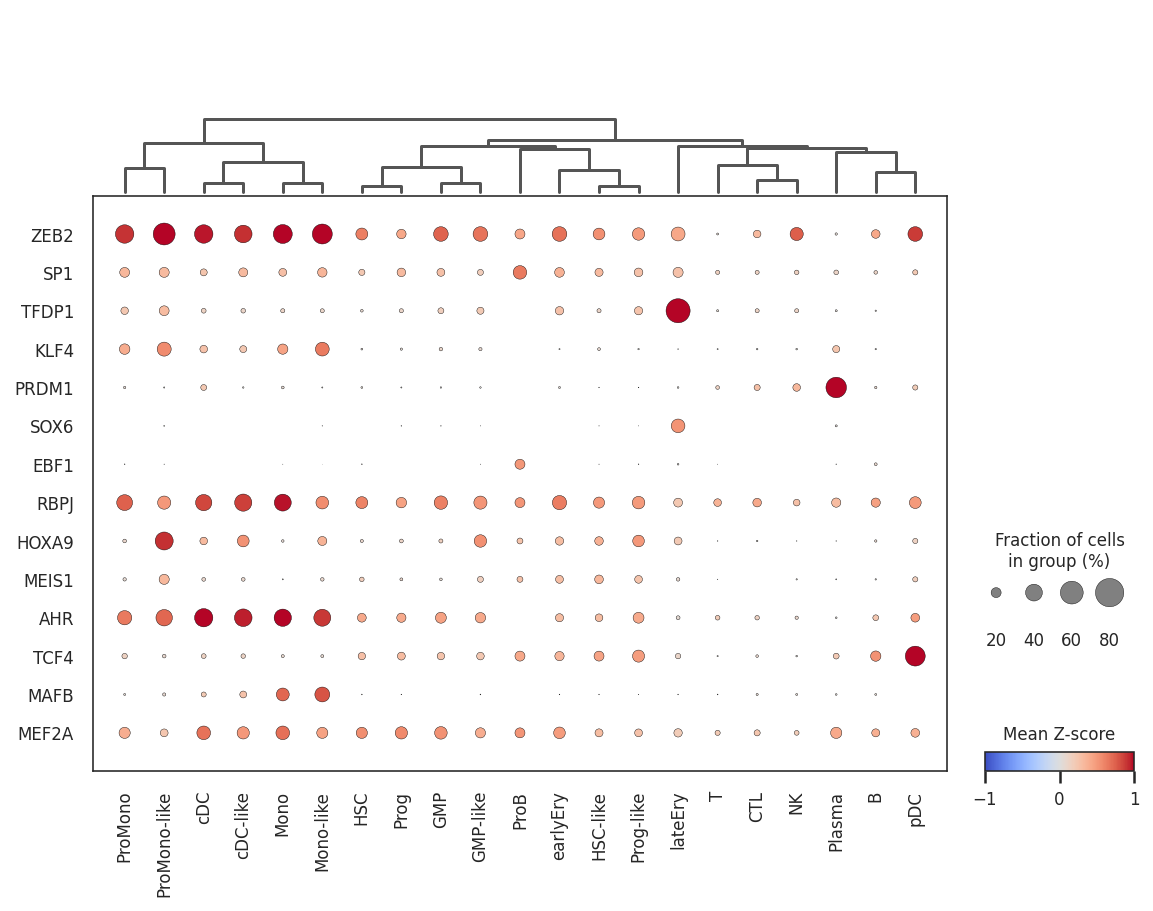

In [ ]:
sc.pl.dotplot(AMLadata, ['ZEB2', 'SP1', 'TFDP1', 'KLF4', 'PRDM1', 'SOX6', 'EBF1', 'RBPJ', 'HOXA9', 'MEIS1', 'AHR', 'TCF4', 'MAFB', 'MEF2A'],
              groupby = "CellType", #layer="scaled", 
              dendrogram=True,
              vmin=-1, vmax=1, cmap="coolwarm", colorbar_title="Mean Z-score", dot_max=0.8, swap_axes = True)

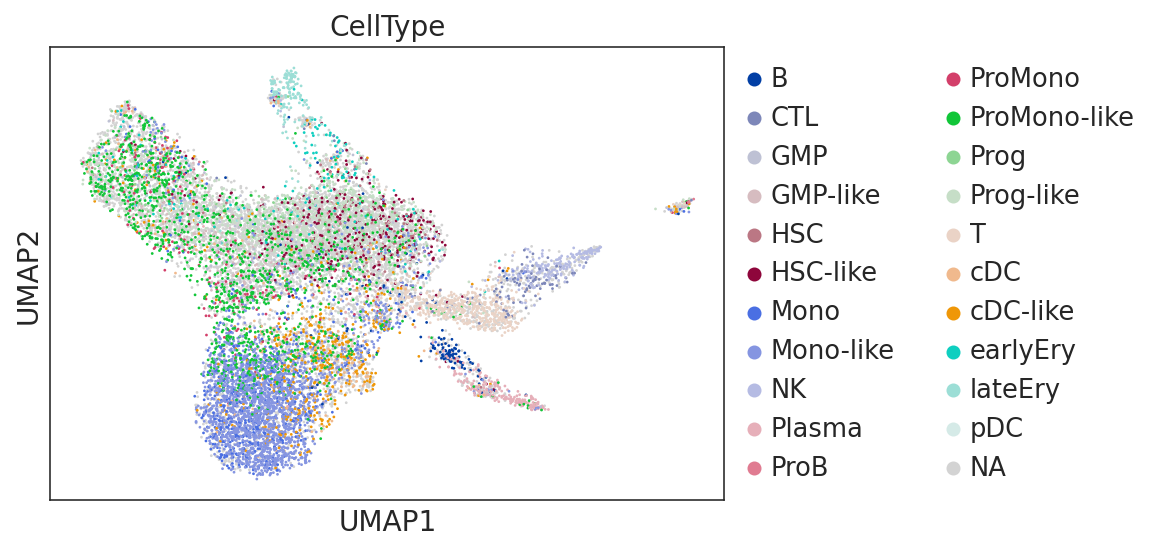

In [ ]:
sc.pl.umap(AMLadata, color="CellType")

## And a little bit more...

Now we will look for marker genes describing each cluster.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:29)


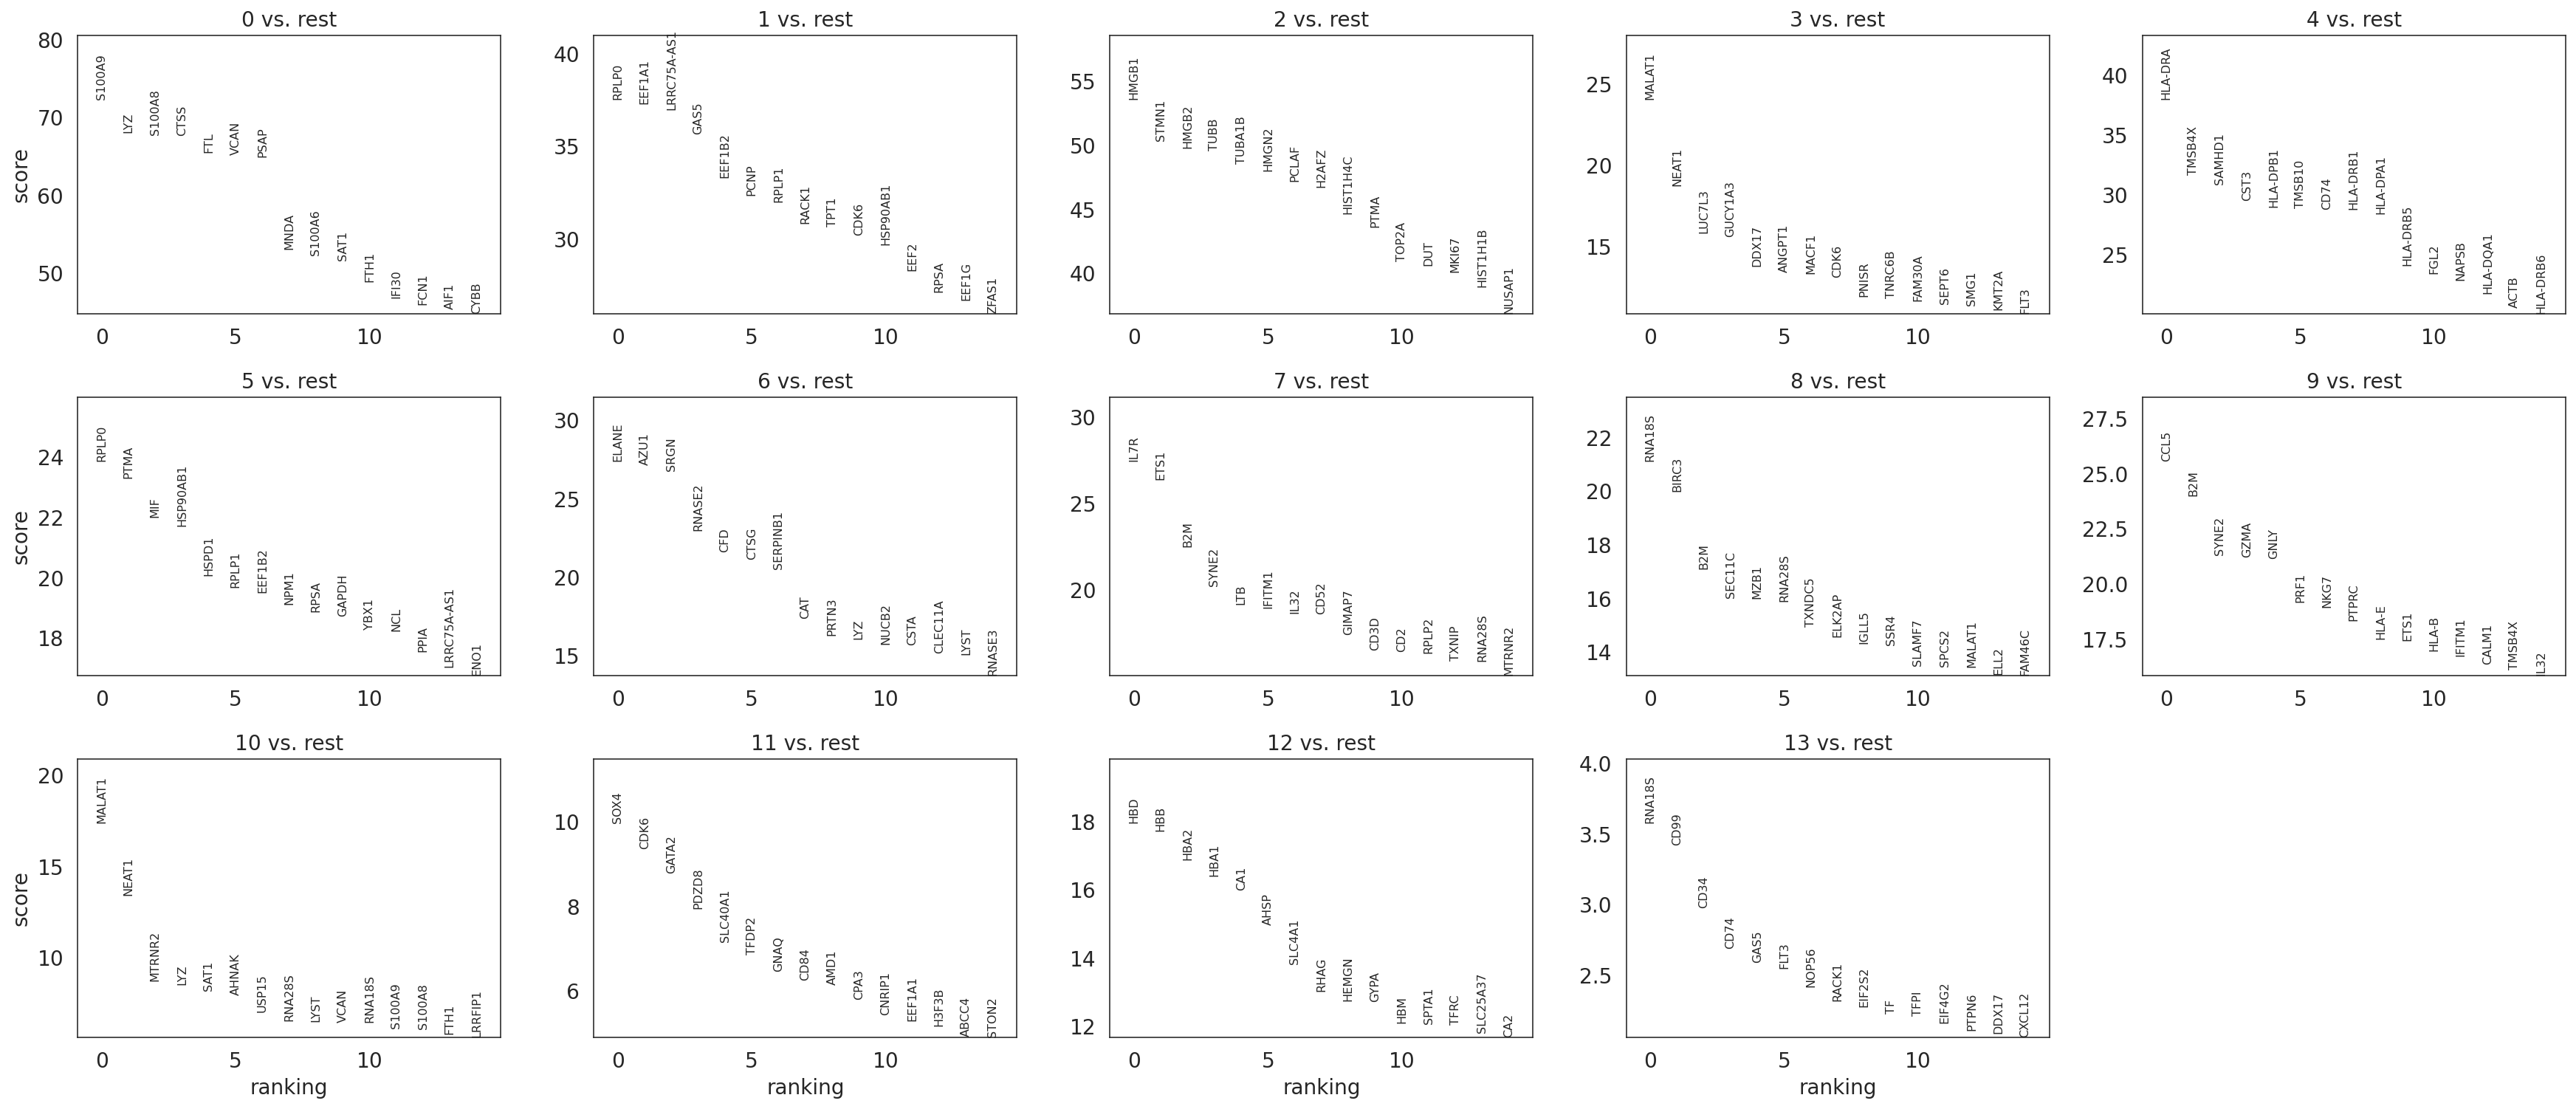

In [ ]:
sc.tl.rank_genes_groups(AMLadata, "leiden", method="wilcoxon") # searching for marker genes
sc.pl.rank_genes_groups(AMLadata, n_genes=15, sharey=False, ncols=5) # the list of marker genes

It is better to visualize the genes that are specifically expressed in one or two cell types. The expression of genes obtained at the previous steps can be checked using UMAP imaging. 

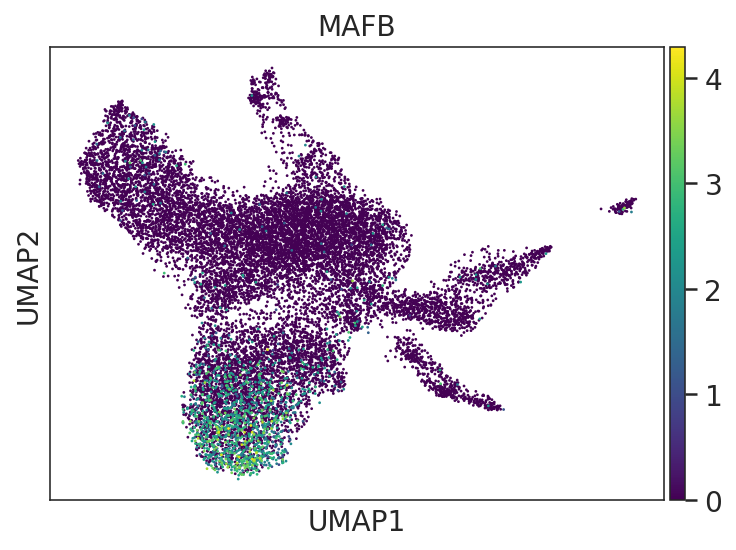

In [ ]:
sc.pl.umap(AMLadata, color=['MAFB'], color_map='viridis')